# QCNNs with mid circuit measurements, reset and feedforward

#### In this notebook I demonstrate the workflow of training a qcnn with the techniques shown in my paper

All the imports needed for the notebook, install packages from requirements.txt if you miss something (imports might take some time)

In [1]:
import numpy as np
import os
import sys
from qiskit.visualization.circuit_visualization import circuit_drawer
from qiskit_aer import Aer, AerSimulator
import pickle
from qiskit import transpile
import matplotlib.pyplot as plt
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_machine_learning.optimizers import COBYLA, SPSA, ADAM, L_BFGS_B
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Add the src directory to the path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..', 'src')))
from utils import no_op_minimizer, generate_dataset
from prebuilt_cicuits import get_circuit
from callbacks import EarlyStoppingCallback, SPSACallbackWrapper
from param_init import init_params_aligned
from amp_encode.utils_amp import images_to_angles_batch_dual

All the runtime variables are editable in the cell below, be aware that not every combination of them has a prebuilt circuit

In [2]:
# runtime variables
use_adap_pool = False
epochs = 400               
num_train = 100             # keep them even for balanced datasets
num_val = 74
num_val_quick = 15
num_test = 250              # default: 250
extended_val_interval = 5   # set to 0 to disable

n=4; m=4; stripe_len=3      # image dimensions
num_qubits_in = 8; num_qubits_out = 1
patience = -1               # negative to disable
save_every_x_epoch = 40
noise_scale_on_images = 0.5 # Give a noise in [0, 1] - Use 0.5 as default
USE_OPTIMIZER = 'COBYLA'    # Options: 'COBYLA'/'SPSA'
USE_FEATURE_MAP = 'angle'   # Options: 'angle' / 'amplitude'
seed = 1111
saved_model_name = f"{seed}_{use_adap_pool}adap_{USE_FEATURE_MAP[:3]}_{n}x{m}.pkl"
output_dir = os.path.join("output", saved_model_name.split(".")[0])


# Circuit selection

As a quick demonstration we are going to work with the 4x4 cicuit from the paper, that applied two stages of reuse, and is directly optimized for the dataset

Using circuit_4x4_8in_horizontal


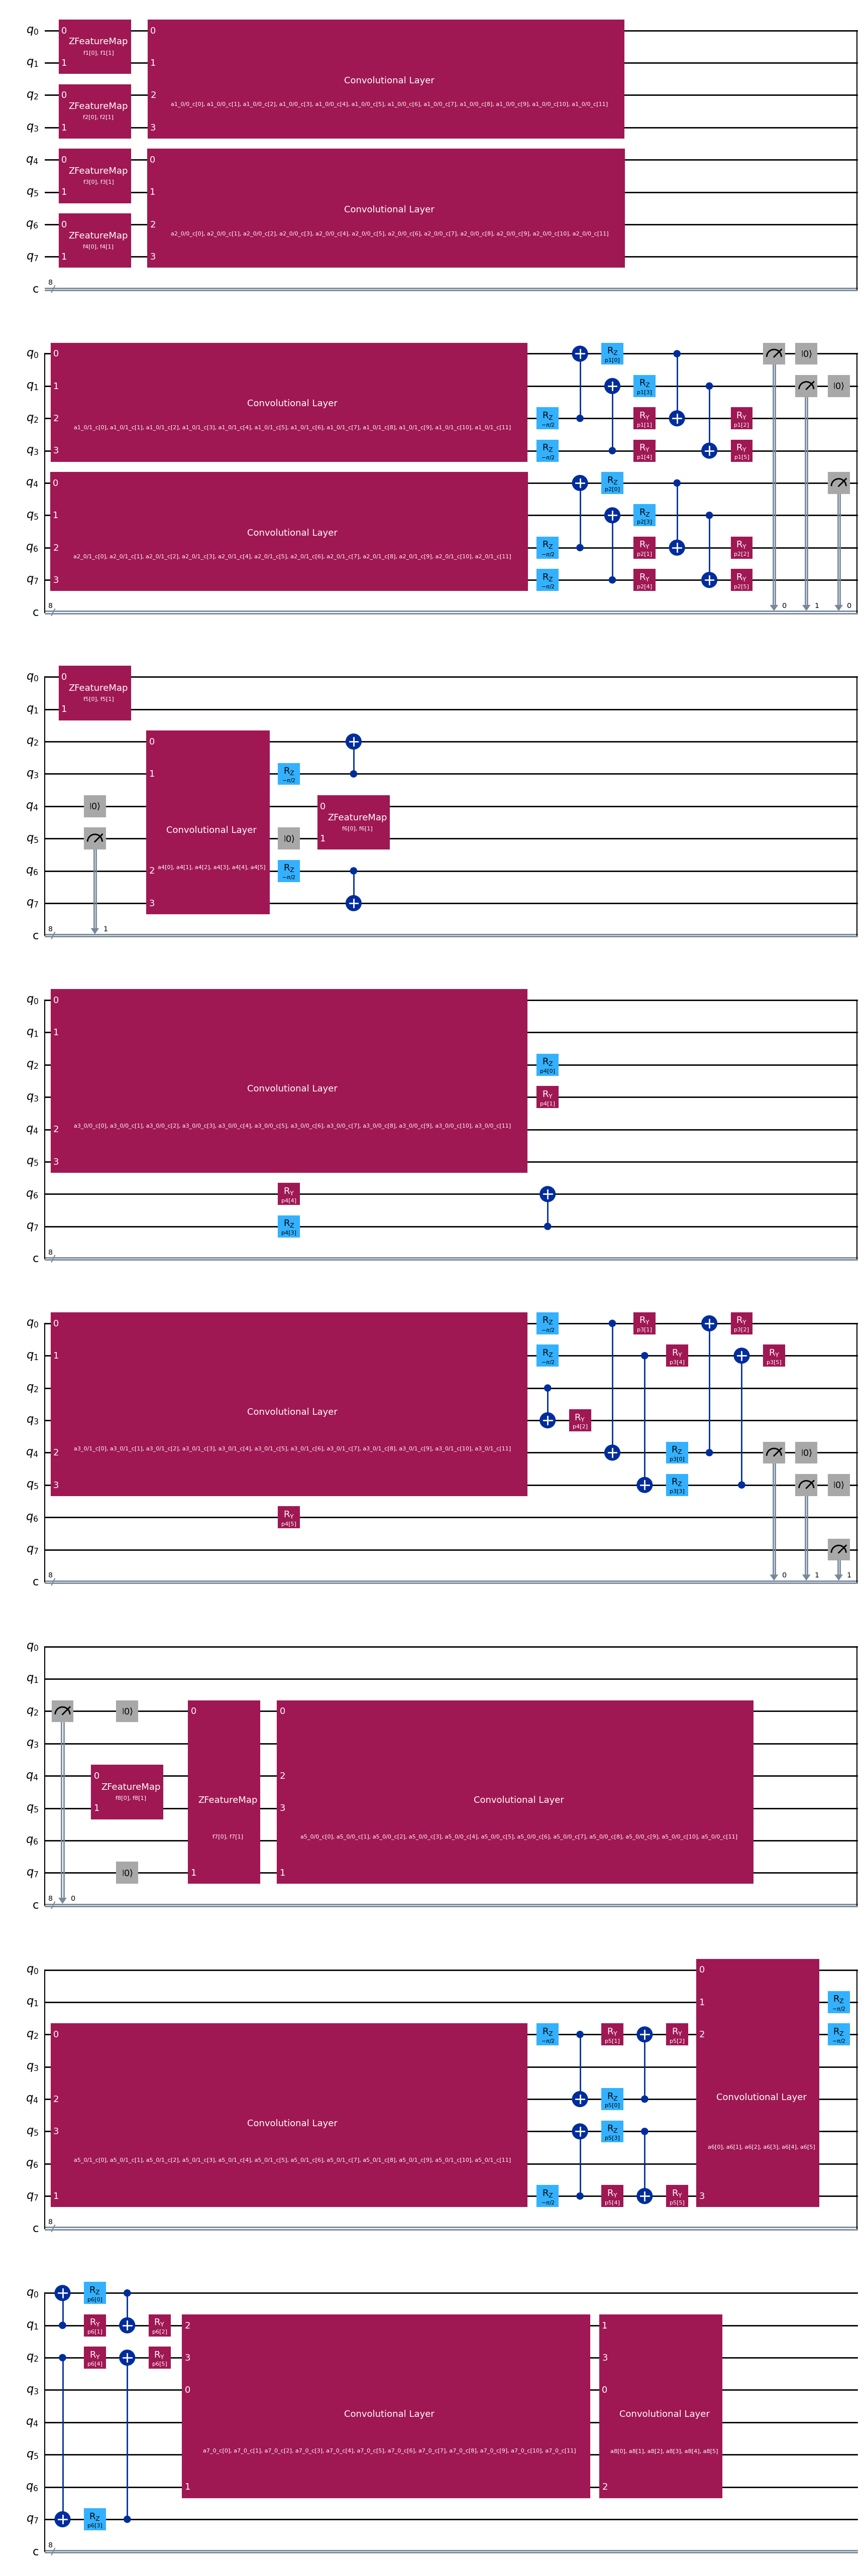

In [3]:
full_circuit, input_params, weight_params, observable = get_circuit(
    n, m, num_qubits_in, num_qubits_out,
    reset_source=False,
    use_adap_pool=use_adap_pool,
    feature_map_type=USE_FEATURE_MAP,
    secret_string="",
)
full_circuit.draw(output="mpl")


# Backend setup
We can either use a simulator or a real quantum computer

In [4]:
use_real_quantum_backend = False
backend = None

if use_real_quantum_backend:
    token = os.getenv("IBM_QUANTUM_TOKEN")
    if not token: raise ValueError("IBM_QUANTUM_TOKEN environment variable not set! Run: $env:IBM_QUANTUM_TOKEN='your_token'")
    service = QiskitRuntimeService(channel="ibm_cloud", token=token)

    # Get the least busy backend
    backend = service.least_busy(operational=True, simulator=False) # for cloud ibm quantum computer
    print(f"Using backend: {backend.name}")
else:
    backend = AerSimulator(
        method='statevector',
        device='CPU', # This could be GPU but linux or custom build is needed
        max_parallel_threads=0
    )
    print(f"Using AerSimulator on {backend.options.device} with {backend.options.max_parallel_threads} threads")

Using AerSimulator on CPU with 0 threads


In [5]:
# Generate the preset pass manager for the backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

# Transpile the circuit for the backend
isa_circuit = pm.run(full_circuit)
isa_observables = observable.apply_layout(isa_circuit.layout)
print("After transpile: depth=", isa_circuit.depth(), "gates=", isa_circuit.size())

# Create the estimator with the backend
estimator = Estimator(mode=backend)

# Create the QNN with the estimator
qnn = EstimatorQNN(circuit=isa_circuit, observables=isa_observables, input_params=input_params,
                   weight_params=weight_params, estimator=estimator)

#isa_circuit.decompose().draw("mpl")

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


After transpile: depth= 122 gates= 422


 # Generate the dataset 
 Here we create the seeded stripe dataset with the given runtime variables to learn on

Angle encoding: train_images shape = (100, 16)


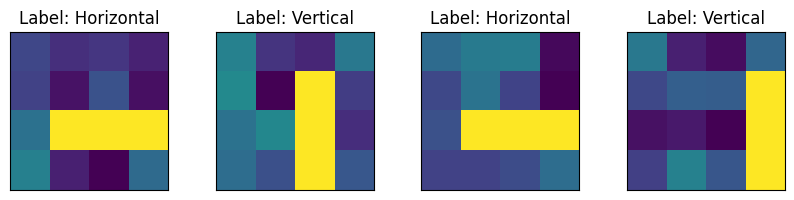

In [6]:
train_images, train_labels = generate_dataset(num_train, noise_scale=noise_scale_on_images, n=n, m=m, stripe_length=stripe_len, seed=seed)
val_images, val_labels = generate_dataset(num_val, noise_scale=noise_scale_on_images, n=n, m=m, stripe_length=stripe_len, seed=seed+1)
test_images, test_labels = generate_dataset(num_test, noise_scale=noise_scale_on_images, n=n, m=m, stripe_length=stripe_len, seed=seed+2)

# Keep 2D versions for plotting (always needed regardless of feature map type)
imgs_train_2d = [np.asarray(img, dtype=float).reshape(n, m) for img in train_images]
imgs_val_2d = [np.asarray(img, dtype=float).reshape(n, m) for img in val_images]
imgs_test_2d = [np.asarray(img, dtype=float).reshape(n, m) for img in test_images]

# Preprocess images based on feature map type
if USE_FEATURE_MAP == 'amplitude':
    # Amplitude encoding: convert flat images to amplitude angles (dual encoding: rows + columns)
    target_len = 16  # 2^4 for 3x4=12 pixels padded to next power of 2
    train_images = images_to_angles_batch_dual(imgs_train_2d, target_length=target_len)
    val_images = images_to_angles_batch_dual(imgs_val_2d, target_length=target_len)
    test_images = images_to_angles_batch_dual(imgs_test_2d, target_length=target_len)
    print(f"Amplitude encoding: train_images shape = {train_images.shape}")
else:
    # Angle encoding: use images as-is (flat vectors)
    train_images = np.asarray(train_images)
    val_images = np.asarray(val_images)
    test_images = np.asarray(test_images)
    print(f"Angle encoding: train_images shape = {train_images.shape}")

# Plot some examples from the training set in one row
fig, ax = plt.subplots(1, 4, figsize=(10, 3), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i].imshow(imgs_train_2d[i], aspect="equal")
    ax[i].set_title(f"Label: {'Horizontal' if train_labels[i] == -1 else 'Vertical'}")
plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.show()

Configuring the classifier that we are going to train

In [7]:
initial_point = init_params_aligned(qnn, is_adap_pooled=use_adap_pool, adaptive_pool_gates=["a1_0_p"], seed=seed, do_print=True)

# Instantiate the early stopping callback after data is ready
training_callback = EarlyStoppingCallback(
    qnn=qnn,
    val_images=val_images,
    val_labels=val_labels,
    output_dir=output_dir,
    saved_model_name=saved_model_name,
    save_every_x_epoch=save_every_x_epoch,
    patience=patience,
    plot=True,
    quick_val_size=num_val_quick,
    extended_val_interval=extended_val_interval,
)

# Dynamic optimizer selection based on USE_OPTIMIZER variable
if USE_OPTIMIZER == 'SPSA':
    print(f"Using SPSA optimizer with maxiter={epochs}")
    # SPSA requires callback to be passed to SPSA itself, not to NeuralNetworkClassifier
    spsa_callback_wrapper = SPSACallbackWrapper(training_callback)
    classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=SPSA(maxiter=epochs, callback=spsa_callback_wrapper),
        callback=None,  # Must be None when using SPSA's callback
        initial_point=initial_point,
    )
elif USE_OPTIMIZER == 'COBYLA':
    print(f"Using COBYLA optimizer with maxiter={epochs}")
    # COBYLA/other optimizers: pass callback directly to NeuralNetworkClassifier
    classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=COBYLA(maxiter=epochs),
        callback=training_callback,
        initial_point=initial_point,
    )
else:
    raise ValueError(f"Unknown optimizer: {USE_OPTIMIZER}. Use 'SPSA'/'COBYLA'")

Non-adaptive model: returning 162 random params
Extended validation enabled:
  - Quick validation: 15 images (every epoch)
  - Extended validation: 74 images (every 5 epochs)
Using COBYLA optimizer with maxiter=400


# Fitting the model on the training data

Training can take time up to an hour, for demonstration purpses `do_train` is `False` by default, feel free to change it.

This was the training plot of the loaded model:


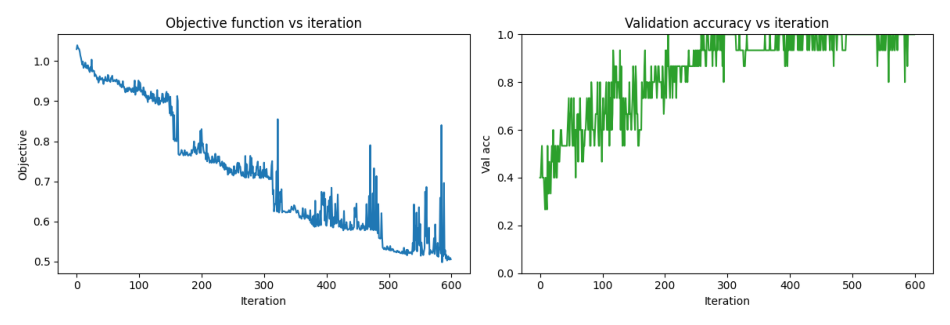

In [12]:
do_train = False
if do_train:
    plt.rcParams["figure.figsize"] = (12, 6)

    x = np.asarray(train_images)
    y = np.asarray(train_labels)

    # Fit with early stopping handling
    try:
        classifier.fit(x, y)
    except RuntimeError as e:
        if str(e) == "EARLY_STOPPING_TRIGGERED":
            best_weights, best_obj, best_val = training_callback.get_best()
            print(f"Early stopping after {training_callback.epoch_idx} iterations. Best val acc: {best_val:.4f}")
        else:
            raise
else:
    # Load a pretrained model (note that this only works for certain runtime variables since we load specific weights)
    model_to_load = os.path.join("..", "model_weights", "last_" + saved_model_name)
    with open(model_to_load, 'rb') as f:
        trained_params = pickle.load(f)

    # Then rebuild classifier with trained weights
    classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=no_op_minimizer,
        callback=None,
        initial_point=trained_params['weights']
    )
    
    # Show the training plot: ../model_weights/training_plot_last_xxx.png
    print("This was the training plot of the loaded model:")
    plot_name = f"training_plot_last_{saved_model_name}".replace('.pkl', '.png')
    plt.figure(figsize=(12, 6)); plt.imshow(plt.imread(os.path.join("..", "model_weights", plot_name))); plt.axis('off'); plt.show()

# Evauating the model

We evaluate the model on the test dataset

This might take a minute since, simulating mid circuit measruement required a classical hardware to branch the possible outcomes

Using trained_params
Accuracy from the test data : 99.2%
Accuracy from the test data : 99.2%


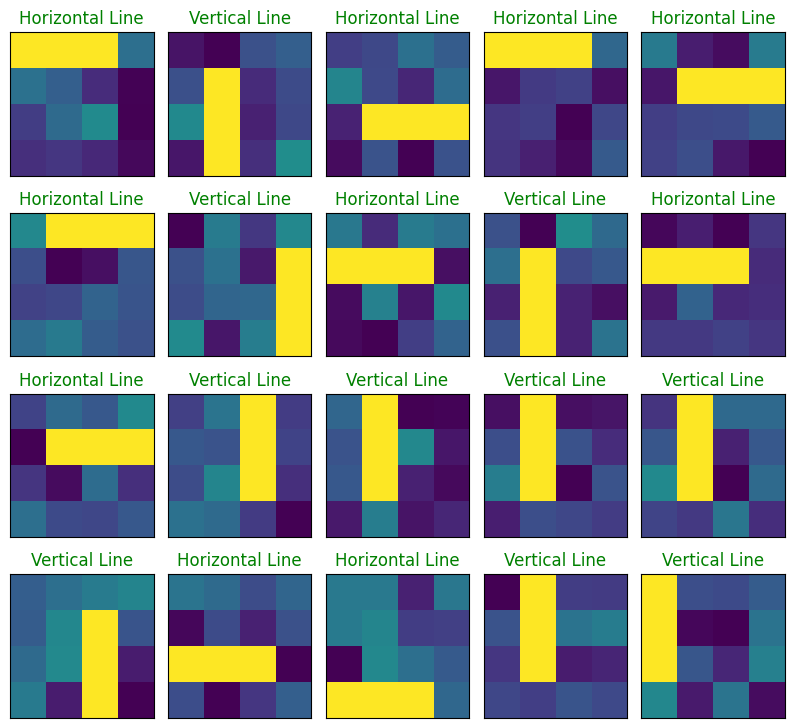

In [13]:
try:
    weights = trained_params['weights'] # type: ignore
    print("Using trained_params")
except:
    best_weights, _ = training_callback.get_best_extended_val()
    weights = best_weights
    print("Using best_weights")

x = np.asarray(test_images)
y = np.asarray(test_labels)

# Forward pass through QNN
raw = qnn.forward(x, weights)

# Convert raw outputs to class labels {-1, +1} with threshold at 0
raw = np.asarray(raw).reshape(-1)
y_predict = np.where(raw >= 0.0, 1, -1)

# Compute accuracy
acc = float(np.mean(y_predict == y))
print(f"Accuracy from the test data : {np.round(100 * acc, 2)}%")

# Let's see some examples in our test dataset (use 2D images for plotting)
fig, ax = plt.subplots(4, 5, figsize=(10, 9), subplot_kw={"xticks": [], "yticks": []})
for i in range(min(20, len(x))):
    ax[i // 5, i % 5].imshow(imgs_test_2d[i], aspect="equal")
    color = 'green' if y_predict[i] == y[i] else 'red'
    ax[i // 5, i % 5].set_title("Horizontal Line" if y_predict[i] == -1 else "Vertical Line", color=color)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

#### Save the model and its parameters with all runtime variables

In [10]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

best_weights, best_obj, best_val = training_callback.get_best()
best_ext_val_weights, best_ext_val_acc = training_callback.get_best_extended_val()
trained_params = {
    'weights': best_weights if best_weights is not None else classifier._fit_result.x,
    'objective_values': training_callback.get_histories()[0],
    'val_acc_history': training_callback.get_histories()[1],
    'extended_val_acc_history': training_callback.get_extended_val_history(),
    'best_objective_value': best_obj,
    'best_val_accuracy': best_val,
    'best_extended_val_accuracy': best_ext_val_acc,
    'best_extended_val_weights': best_ext_val_weights,
}

with open(os.path.join(output_dir, f"last_{saved_model_name}"), 'wb') as f:
    pickle.dump(trained_params, f)

# Also dump runtime variables (cell 2) and the circuit used (cell 3) into a text file
info_path = os.path.join(output_dir, "run_info.txt")

# Gather runtime variables
runtime_vars = {
    "use_adap_pool": use_adap_pool,
    "epochs": epochs,
    "num_train": num_train,
    "num_val": num_val,
    "num_val_quick": num_val_quick,
    "num_test": num_test,
    "extended_val_interval": extended_val_interval,
    "n": n,
    "m": m,
    "stripe_len": stripe_len,
    "num_qubits_in": num_qubits_in,
    "num_qubits_out": num_qubits_out,
    "patience": patience,
    "save_every_x_epoch": save_every_x_epoch,
    "noise_scale_on_images": noise_scale_on_images,
    "USE_OPTIMIZER": USE_OPTIMIZER,
    "USE_FEATURE_MAP": USE_FEATURE_MAP,
    "seed": seed,
    "saved_model_name": saved_model_name,
    "output_dir": output_dir,
}

with open(info_path, "w", encoding="utf-8") as f:
    f.write("Runtime variables:\n")
    for k, v in runtime_vars.items():
        f.write(f"{k} = {v}\n")


#### In case you wish to load it back later:

In [8]:
# Rebuild the qnn (you must run the code that defines `qnn` first!)
model_to_load = "last_"+saved_model_name
with open(os.path.join(output_dir, model_to_load), 'rb') as f:
    trained_params = pickle.load(f)

# Then rebuild classifier with trained weights
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=no_op_minimizer,
    callback=None,
    initial_point=trained_params['weights']
)